Problem 10 (Chap 14). Use transfer learning for large image classification, going through these steps:

(a) Create a training set containing at least 100 images per class. For example, you could classify your own pictures based on the location (beach, mountain, city, etc.), or alternatively you can use an existing dataset (e.g., from TensorFlow Datasets).  You can use the flower data but see (b) 

(b) Split it into a training set, a validation set, and a test set.  (If you use the "flower data" from Chap 14, define the train/validation split (from the "non-test" dataset) through the  function train_test_split(X, y, random_state=num4). Set the random seed num4 to the last 4 digits of your student ID)

(c) Build the input pipeline, including the appropriate preprocessing operations, and optionally add data augmentation.  

(d) Fine-tune a pretrained model on this dataset.

NB: If you want to use custom data (or data outside keras/tensor flow) use the approach from here :

https://towardsdatascience.com/loading-custom-image-dataset-for-deep-learning-models-part-1-d64fa7aaeca6    (packages CV2 or PIL)

https://towardsdatascience.com/input-pipeline-for-images-using-keras-and-tensorflow-c5e107b6d7b9    (keras/TF)



In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

#try:
#    # %tensorflow_version only exists in Colab.
#    %tensorflow_version 2.x
#    IS_COLAB = True
#except Exception:
#    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

#if not tf.config.list_physical_devices('GPU'):
#    print("No GPU was detected. CNNs can be very slow without a GPU.")
#    if IS_COLAB:
#        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

from functools import partial

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("cats_vs_dogs", as_supervised=True, with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteLA5A4C/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
info.splits

{'train': <tfds.core.SplitInfo num_examples=23262>}

In [ ]:
info.splits["train"]

<tfds.core.SplitInfo num_examples=23262>

In [ ]:
class_names = info.features["label"].names
class_names

['cat', 'dog']

In [ ]:
n_classes = info.features["label"].num_classes

In [ ]:
dataset_size = info.splits["train"].num_examples
dataset_size

23262

In [ ]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "cats_vs_dogs",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

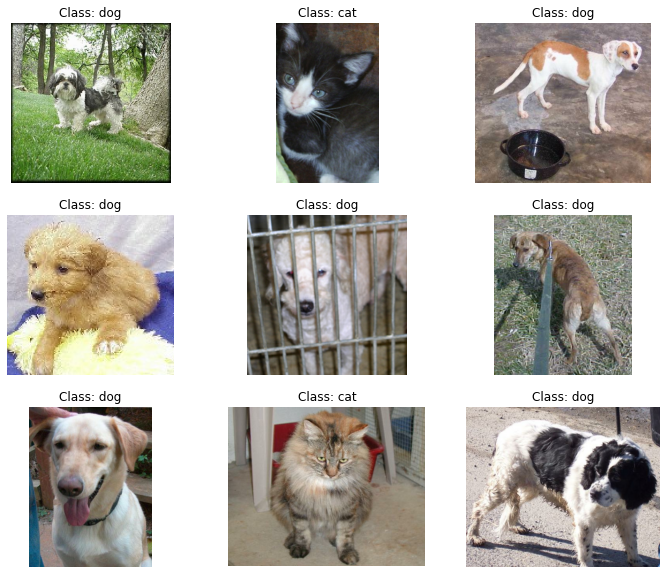

In [ ]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [ ]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [ ]:
# Because 1738 images were corrupted and were skipped, we are going to augment the data
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

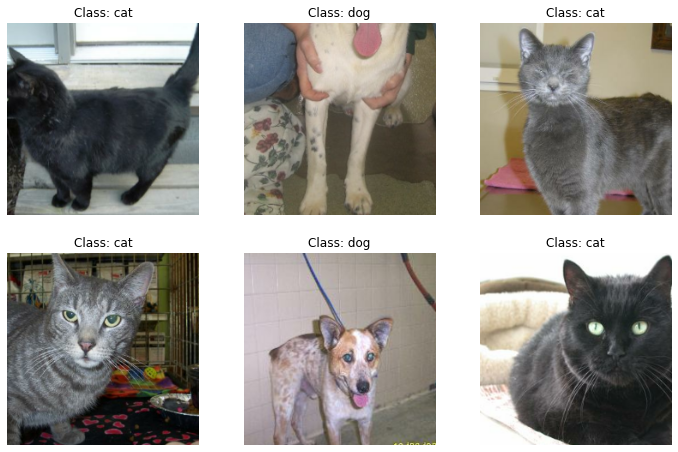

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(6):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

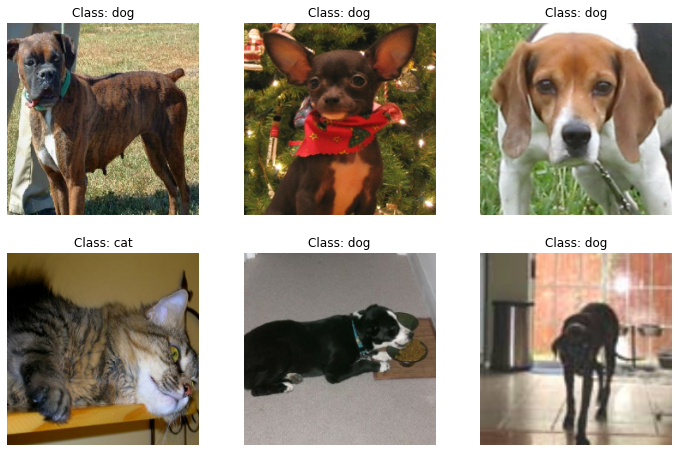

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(6):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 0s 0us/step


In [ ]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [ ]:
## Freeze the weights of the layers from the pretrained model
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
545/545 [==============================] - 88s 157ms/step - loss: 0.0046 - accuracy: 0.9992 - val_loss: 0.0302 - val_accuracy: 0.9911
Epoch 2/5
545/545 [==============================] - 85s 156ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.0302 - val_accuracy: 0.9911
Epoch 3/5
545/545 [==============================] - 85s 156ms/step - loss: 0.0034 - accuracy: 0.9990 - val_loss: 0.0303 - val_accuracy: 0.9908
Epoch 4/5
545/545 [==============================] - 85s 156ms/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.0301 - val_accuracy: 0.9908
Epoch 5/5
545/545 [==============================] - 85s 156ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.0301 - val_accuracy: 0.9911


In [ ]:
# Use model to evaluate on test data
model.evaluate(test_set)

73/73 [==============================] - 10s 130ms/step - loss: 0.0484 - accuracy: 0.9888


[0.048393577337265015, 0.9888219833374023]

In [ ]:
# Now, unfreeze and use much smaller learning rate
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
545/545 [==============================] - 345s 626ms/step - loss: 0.0104 - accuracy: 0.9965 - val_loss: 0.0333 - val_accuracy: 0.9891
Epoch 2/5
545/545 [==============================] - 338s 620ms/step - loss: 0.0068 - accuracy: 0.9980 - val_loss: 0.0327 - val_accuracy: 0.9900
Epoch 3/5
545/545 [==============================] - 338s 620ms/step - loss: 0.0067 - accuracy: 0.9978 - val_loss: 0.0267 - val_accuracy: 0.9905
Epoch 4/5
545/545 [==============================] - 338s 619ms/step - loss: 0.0043 - accuracy: 0.9986 - val_loss: 0.0285 - val_accuracy: 0.9908
Epoch 5/5
545/545 [==============================] - 339s 623ms/step - loss: 0.0027 - accuracy: 0.9989 - val_loss: 0.0292 - val_accuracy: 0.9917


In [ ]:
# Use model to evaluate on test data
model.evaluate(test_set)

73/73 [==============================] - 10s 129ms/step - loss: 0.0450 - accuracy: 0.9905


[0.045042283833026886, 0.9905416965484619]

Our model did fairly well, and this can be due to the fact that we have a lot of data for classifying only two classes.